## Load packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import numpy as np
import seaborn as sns

## Specify filepaths

In [2]:
layout_path = 'data/20230817_layout.xlsx'
plate_data = 'data/20230817_FUR_validations.xlsx'
graph_outpath = 'graphs/'

## Import layout

In [3]:
layout = pd.read_excel(layout_path, header=0)
layout

,well,strain,RA_well,mutation,mutation_type,pMOBY
0,A1,LL13-040,E3,Q17*,stop,empty
1,A2,LL13-040,E3,Q17*,stop,FUR1
2,A3,LL13-040,L7,S145N,non-synonymous,empty
3,A4,LL13-040,L7,S145N,non-synonymous,FUR1
4,A5,NC-02,N22,Q17*,stop,empty
...,...,...,...,...,...,...
63,H5,NC-02,K14,Y121H,non-synonymous,empty
64,H6,NC-02,K14,Y121H,non-synonymous,FUR1
65,H7,NC-02,NaN,deletion,deletion,empty
66,H8,NC-02,NaN,deletion,deletion,FUR1


## Get data from plate reader

In [4]:
def get_data(fpath):
    from datetime import datetime, date, time
    
    source_df = pd.read_excel(fpath, index_col=0, header=0, skiprows=40, skipfooter=36).reset_index(drop=True)
    
    t0, t1 = source_df.iloc[[0,1],0] # Get the first and second timepoints
    
    # Convert first timepoint from time (of the day) object to time duration (h)
    t0_h = (datetime.combine(date.today(), t0) - datetime.combine(date.today(), time.min)).total_seconds() / 3600
    
    # Convert difference between second and first timepoint into duration in h (measurement interval)
    delta = (datetime.combine(date.today(), t1) - datetime.combine(date.today(), t0)).total_seconds() / 3600
    
    # Rewrite column of timepoints using calculated values
    source_df['Time'] = np.arange(t0_h, t0_h + len(source_df.Time)*delta, delta)
    
    # Delete column with temperature
    source_df.drop(columns='T° 595', inplace=True)
    
    # Wide to long format
    longdf = source_df.melt(id_vars = 'Time', var_name = 'well', value_name = 'OD')
    
    return longdf

In [5]:
plate = get_data(plate_data)
plate

,Time,well,OD
0,0.237778,A1,0.103
1,0.487778,A1,0.105
2,0.737778,A1,0.107
3,0.987778,A1,0.108
4,1.237778,A1,0.110
...,...,...,...
13891,47.237778,H9,0.825
13892,47.487778,H9,0.824
13893,47.737778,H9,0.825
13894,47.987778,H9,0.825


In [6]:
merged = plate.merge(right=layout, on='well')
merged

,Time,well,OD,strain,RA_well,mutation,mutation_type,pMOBY
0,0.237778,A1,0.103,LL13-040,E3,Q17*,stop,empty
1,0.487778,A1,0.105,LL13-040,E3,Q17*,stop,empty
2,0.737778,A1,0.107,LL13-040,E3,Q17*,stop,empty
3,0.987778,A1,0.108,LL13-040,E3,Q17*,stop,empty
4,1.237778,A1,0.110,LL13-040,E3,Q17*,stop,empty
...,...,...,...,...,...,...,...,...
13119,47.237778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1
13120,47.487778,H9,0.824,NC-02,G21,P138R,non-synonymous,FUR1
13121,47.737778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1
13122,47.987778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1


## Visualize growth curves

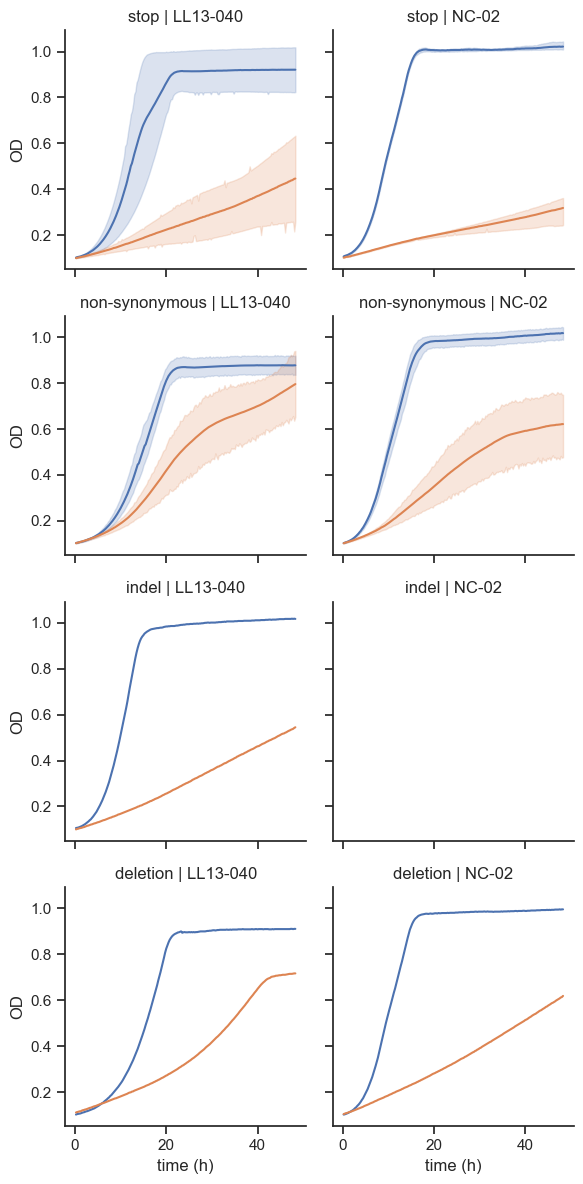

In [7]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
grid = sns.FacetGrid(data=merged, col = 'strain', row= 'mutation_type', hue='pMOBY')
grid.map(sns.lineplot, 'Time', 'OD')
grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('time (h)', 'OD')
#grid.add_legend(title = 'pMOBY')
grid.fig.subplots_adjust(top=0.9)
grid.tight_layout()
#plt.savefig('/home/rodur28/growth_curve_files/graphs/20221124_FUR1_growth-curves.svg', format='svg', dpi=300)
#plt.savefig('/home/rodur28/growth_curve_files/graphs/20221124_FUR1_growth-curves.png', format='png', dpi=300)

In [8]:
# Convert well to matrix coordinates
def get_matrix_coordinates(well):
    row_coord = ord(well[0]) - 64
    col_coord = well[1] # quick fix because I know cols here are in single-digits
    return row_coord, col_coord
merged['row'], merged['col'] = zip(*merged.well.map(lambda x: get_matrix_coordinates(x)))
merged

,Time,well,OD,strain,RA_well,mutation,mutation_type,pMOBY,row,col
0,0.237778,A1,0.103,LL13-040,E3,Q17*,stop,empty,1,1
1,0.487778,A1,0.105,LL13-040,E3,Q17*,stop,empty,1,1
2,0.737778,A1,0.107,LL13-040,E3,Q17*,stop,empty,1,1
3,0.987778,A1,0.108,LL13-040,E3,Q17*,stop,empty,1,1
4,1.237778,A1,0.110,LL13-040,E3,Q17*,stop,empty,1,1
...,...,...,...,...,...,...,...,...,...,...
13119,47.237778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1,8,9
13120,47.487778,H9,0.824,NC-02,G21,P138R,non-synonymous,FUR1,8,9
13121,47.737778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1,8,9
13122,47.987778,H9,0.825,NC-02,G21,P138R,non-synonymous,FUR1,8,9


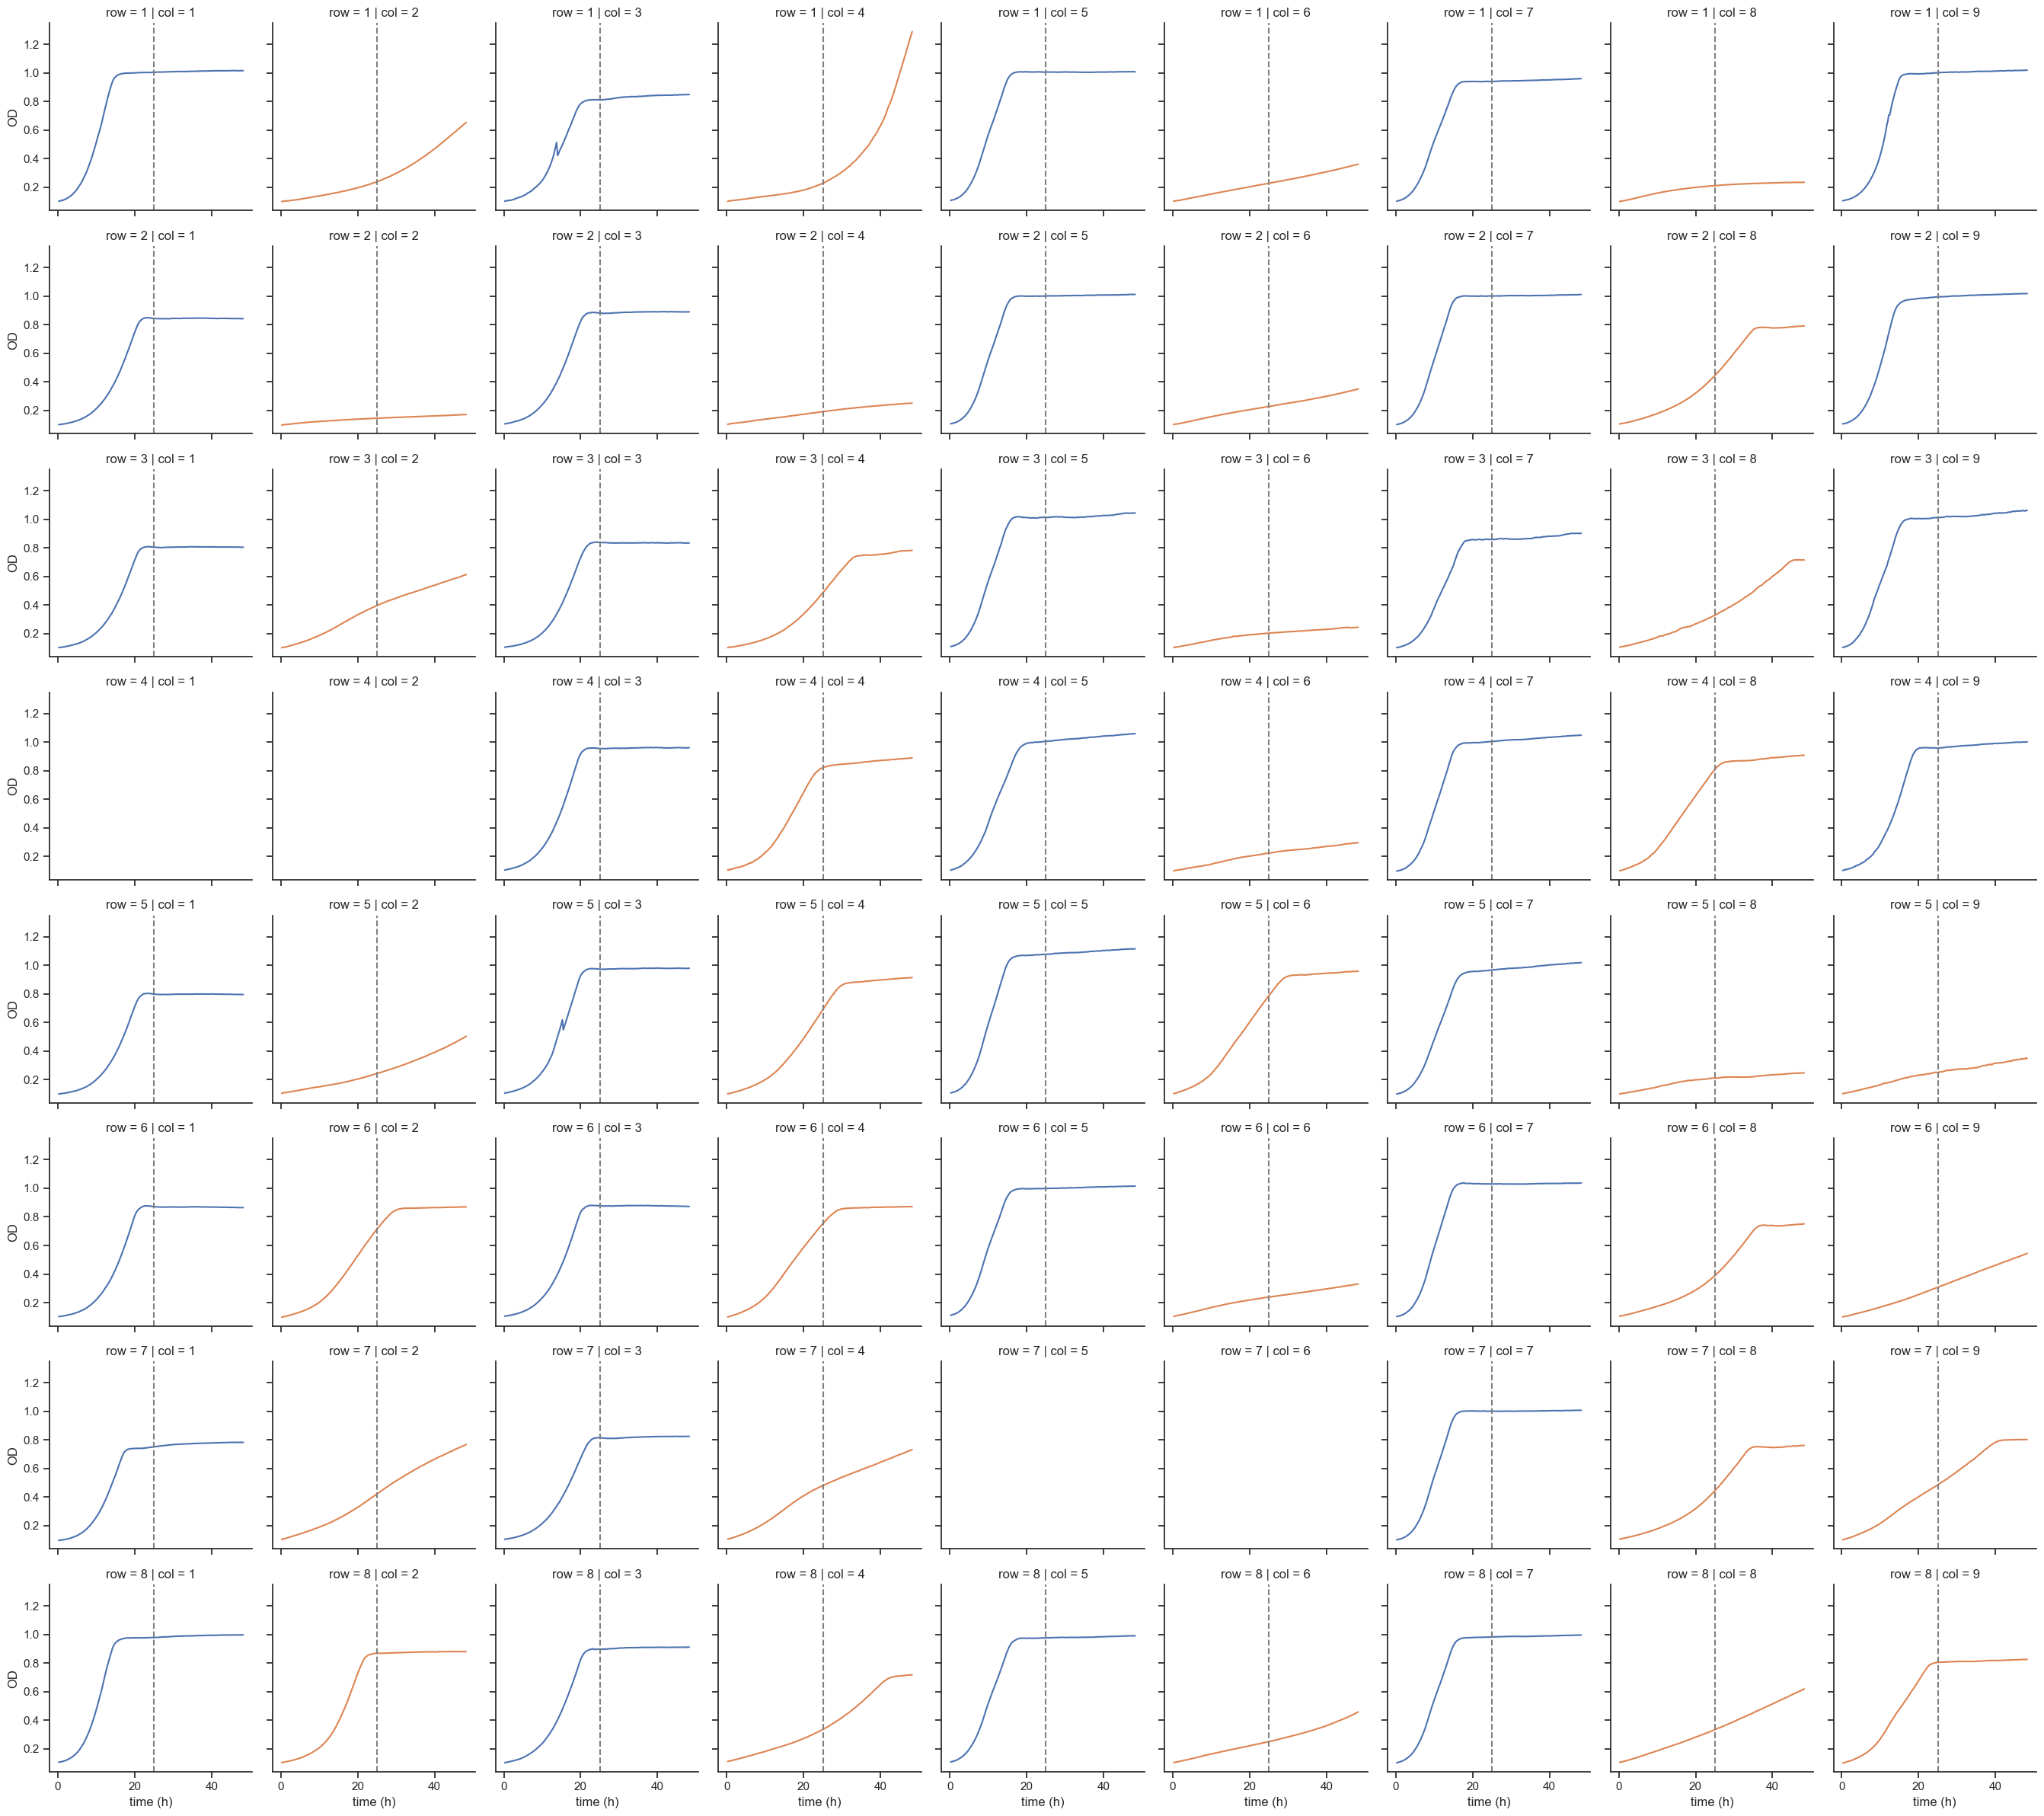

In [9]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
grid = sns.FacetGrid(data=merged,
                     row = 'row', col = 'col',
                     hue='pMOBY')
grid.map(sns.lineplot, 'Time', 'OD')
grid.map(plt.axvline, x=25, ls='--', c='grey')
grid.set_axis_labels('time (h)', 'OD')
#grid.add_legend(title = 'pMOBY')
grid.fig.subplots_adjust(top=0.9)
grid.tight_layout()
#plt.savefig('/home/rodur28/growth_curve_files/graphs/20221124_FUR1_growth-curves.svg', format='svg', dpi=300)
#plt.savefig('/home/rodur28/growth_curve_files/graphs/20221124_FUR1_growth-curves.png', format='png', dpi=300)

## Calculate normalized area under the curve (AUC)

In [10]:
from flucytosine_functions import get_auc
aucdf = merged[merged.Time <= 25].groupby(['strain','mutation','mutation_type','pMOBY','well']
                                         )[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf

,strain,mutation,mutation_type,pMOBY,well,auc
0,LL13-040,A146del,indel,FUR1,F9,19.1935
1,LL13-040,A146del,indel,empty,B9,63.3320
2,LL13-040,F209C,non-synonymous,FUR1,F4,35.7250
3,LL13-040,F209C,non-synonymous,empty,F3,42.6640
4,LL13-040,G104D,non-synonymous,FUR1,F2,31.8390
...,...,...,...,...,...,...
63,NC-02,R95T,non-synonymous,empty,D5,58.5980
64,NC-02,Y121H,non-synonymous,FUR1,H6,17.5365
65,NC-02,Y121H,non-synonymous,empty,H5,61.7995
66,NC-02,deletion,deletion,FUR1,H8,20.9755


In [11]:
def get_fc_auc(g):
    val = g.loc[g.pMOBY=='FUR1', 'auc'].values[0]
    ctrl = g.loc[g.pMOBY=='empty', 'auc'].values[0]
    return val/ctrl

normauc = aucdf.groupby(['strain','mutation','mutation_type']
                       )[['pMOBY','auc']].apply(func=get_fc_auc).reset_index(name='FC_AUC')
normauc

,strain,mutation,mutation_type,FC_AUC
0,LL13-040,A146del,indel,0.303062
1,LL13-040,F209C,non-synonymous,0.837357
2,LL13-040,G104D,non-synonymous,0.772192
3,LL13-040,G104S,non-synonymous,0.440842
4,LL13-040,G205W,non-synonymous,0.797518
5,LL13-040,G207S,non-synonymous,0.634117
6,LL13-040,G210V,non-synonymous,0.736058
7,LL13-040,I106N,non-synonymous,0.549473
8,LL13-040,L107*,stop,0.290005
9,LL13-040,L140P,non-synonymous,0.627423


In [12]:
normauc[normauc.FC_AUC > 0.75]

,strain,mutation,mutation_type,FC_AUC
1,LL13-040,F209C,non-synonymous,0.837357
2,LL13-040,G104D,non-synonymous,0.772192
4,LL13-040,G205W,non-synonymous,0.797518
28,NC-02,P138R,non-synonymous,0.799230


In [69]:
normauc[normauc.mutation_type == 'stop']

,strain,mutation,mutation_type,FC_AUC
8,LL13-040,L107*,stop,0.290005
12,LL13-040,Q17*,stop,0.243403
13,LL13-040,R95*,stop,0.316891
15,LL13-040,Y164*,stop,0.608110
25,NC-02,L119*,stop,0.240983
29,NC-02,Q17*,stop,0.251696
30,NC-02,Q92*,stop,0.256693


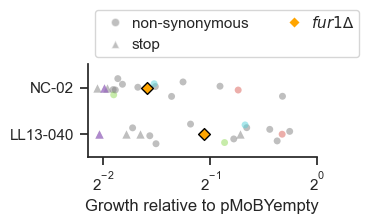

In [68]:
# Create color palette only for mutations tested in both backgrounds (but not deletion)
# Associate grey color with all unique mutations different from the deletion mutant or stop mutations
common_mut = [x for x in normauc[normauc.mutation.duplicated()].mutation if x != 'deletion']
unique_mut = [x for x in normauc.mutation.unique() if (x not in common_mut) & (normauc.loc[normauc.mutation==x, 'mutation_type'].values[0] not in ['deletion','stop']) ]
common_mut_cols = sns.color_palette('hls', len(common_mut)).as_hex()
all_mut_cols = common_mut_cols+['grey']*len(unique_mut)

fig = sns.catplot(data=normauc[(normauc.mutation.isin(common_mut+unique_mut)) & (normauc.mutation_type != 'stop')], y='strain',
                  #order=['LL13-040', 'NC-02'],
                  x='FC_AUC',
                  hue='mutation', palette=dict(zip(common_mut+unique_mut, all_mut_cols)), alpha=.5,
                  jitter=0.25,
                  legend=False, orient='h',
                  height=2.4, aspect=1.56 # height*aspect = width of EACH facet
                 )

# Display stop mutants in triangle markers
fig.axes[0][0].scatter(data=normauc[normauc.mutation_type == 'stop'],
                       x='FC_AUC', y='strain',
                       marker='^', zorder=90, facecolor='grey', alpha=.5, linewidth=0
                      )

for i, m in enumerate(common_mut):
    if m[-1] == '*': # Stop mutants tested in both background
        fig.axes[0][0].scatter(data=normauc[normauc.mutation == m],
                               x='FC_AUC', y='strain',
                               marker='^', zorder=90, facecolor=common_mut_cols[i], alpha=.5, linewidth=0
                              )        

# Display deletion mutants in diamond markers
fig.axes[0][0].scatter(data=normauc[normauc.mutation_type == 'deletion'],
                       x='FC_AUC', y='strain',
                       marker='D', zorder=100, facecolor='orange', edgecolor='black', linewidth=1
                      )

# Display custom legend
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba
handles = [Line2D([0], [0], color='w', marker='o', markerfacecolor=to_rgba('gray',0.5), markersize=10),
           Line2D([0], [0], color='w', marker='^', markerfacecolor=to_rgba('gray',0.5), markersize=10),
           Line2D([0], [0], color='w', marker='D', markerfacecolor=to_rgba('orange'), markersize=10)
          ]
plt.legend(bbox_to_anchor=(0,1), loc='lower left', title=None, frameon=True, ncols=2,
           handles=handles, labels=['non-synonymous', 'stop', u'$\it{fur1}$Δ'],
           markerscale=.6, handletextpad=0.1, borderpad=0.3
          )

# Edit axes
plt.xscale('log',base=2)
fig.set(xlim=(None,1), ylim=(-0.5,1.5), xlabel='Growth relative to pMoBYempty', ylabel='')

# Export figure
fig.tight_layout()
plt.savefig(graph_outpath+'20230821_FUR1_validations.svg', format='svg', dpi=300)